In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:


class LocallySparseNoise():
    """
    generate locally sparse noise stimulus integrates flashing indicator for
    photodiode

    This stimulus routine presents quasi-random noise in a specified region of
    the monitor. The `background` color can be customized but defaults to a
    grey value. Can specify the `subregion` of the monitor where the pixels
    will flash on and off (black and white respectively)

    Different from SparseNoise stimulus which presents only one probe at a time,
    the LocallySparseNoise presents multiple probes simultaneously to speed up
    the sampling frequency. The sparsity of probes is defined by minimum distance
    in visual degree: in any given frame, the centers of any pair of two probes
    will have distance larger than minimum distance in visual degrees. The
    method generate locally sparse noise here insures, for each iteration, all
    the locations in the subregion will be sampled once and only once.

    Parameters
    ----------
    monitor : monitor object
        contains display monitor information
    indicator : indicator object
        contains indicator information
    coordinate : str from {'degree','linear'}, optional
        specifies coordinates, defaults to 'degree'
    background : float, optional
        color of background. Takes values in [-1,1] where -1 is black and 1
        is white
    pregap_dur : float, optional
        amount of time (in seconds) before the stimulus is presented, defaults
        to `2.`
    postgap_dur : float, optional
        amount of time (in seconds) after the stimulus is presented, defaults
        to `3.`
    min_distance : float, default 20.
        the minimum distance in visual degree for any pair of probe centers
        in a given frame
    grid_space : 2-tuple of floats, optional
        first coordinate is altitude, second coordinate is azimuth
    probe_size : 2-tuple of floats, optional
        size of flicker probes. First coordinate defines the width, and
        second coordinate defines the height
    probe_orientation : float, optional
        orientation of flicker probes
    probe_frame_num : int, optional
        number of frames for each square presentation
    subregion : list or tuple
        the region on the monitor that will display the sparse noise,
        list or tuple, [min_alt, max_alt, min_azi, max_azi]
    sign : {'ON-OFF', 'ON', 'OFF'}, optional
        determines which pixels appear in the `subregion`, defaults to
        `'ON-Off'` so that both on and off pixels appear. If `'ON` selected
        only on pixels (white) are displayed in the noise `subregion while if
        `'OFF'` is selected only off (black) pixels are displayed in the noise
    iteration : int, optional
        number of times to present stimulus with random order, the total number
        a paticular probe will be displayded will be iteration * repeat, for
        each iteration, a new sequence will be generated. defaults to `1`
    repeat : int, optional
        number of repeat of whole sequence, the total number a paticular probe
        to be displayded will be iteration * repeat, defaults to `1`
    is_include_edge : bool, default True,
        if True, the displayed probes will cover the edge case and ensure that
        the entire subregion is covered.
        If False, the displayed probes will exclude edge case and ensure that all
        the centers of displayed probes are within the subregion.
    """

    def __init__(self, monitor, min_distance=20., grid_space=(10., 10.), probe_size=(10., 10.), probe_orientation=0.,
                 probe_frame_num=6, subregion=None, sign='ON-OFF', iteration=1, repeat=1):
        """
        Initialize sparse noise object, inherits Parameters from Stim object
        """

#         super(LocallySparseNoise, self).__init__(monitor=monitor, indicator=indicator,
#                                                  background=background, coordinate=coordinate,
#                                                  pregap_dur=pregap_dur, postgap_dur=postgap_dur)
        self.monitor = monitor
        self.stim_name = 'LocallySparseNoise'
        self.grid_space = grid_space
        self.probe_size = probe_size
        self.min_distance = float(min_distance)
        self.probe_orientation = probe_orientation

        #self.is_include_edge = is_include_edge
        self.frame_config = ('is_display', 'probes ((altitude, azimuth, sign), ...)',
                             'iteration', 'indicator color [-1., 1.]')

        if probe_frame_num >= 2:
            self.probe_frame_num = int(probe_frame_num)
        else:
            raise ValueError('SparseNoise: probe_frame_num should be no less than 2.')

        #self.is_include_edge = is_include_edge

#         if subregion is None:
#             if self.coordinate == 'degree':
#                 self.subregion = [np.amin(self.monitor.deg_coord_y),
#                                   np.amax(self.monitor.deg_coord_y),
#                                   np.amin(self.monitor.deg_coord_x),
#                                   np.amax(self.monitor.deg_coord_x)]
#             if self.coordinate == 'linear':
#                 self.subregion = [np.amin(self.monitor.lin_coord_y),
#                                   np.amax(self.monitor.lin_coord_y),
#                                   np.amin(self.monitor.lin_coord_x),
#                                   np.amax(self.monitor.lin_coord_x)]
#         else:
#             self.subregion = subregion

        self.sign = sign

        if iteration >= 1:
            self.iteration = int(iteration)
        else:
            raise ValueError('iteration should be no less than 1.')

        if repeat >= 1:
            self.repeat = int(repeat)
        else:
            raise ValueError('repeat should be no less than 1.')

        #self.clear()

    def _get_grid_locations(self, is_plot=False):
        """
        generate all the grid points in display area (covered by both subregion and
        monitor span)

        Returns
        -------
        grid_points : n x 2 array,
            refined [azi, alt] pairs of probe centers going to be displayed
        """

        alt_probe_coords = np.linspace(monitor.alt_min_coord, 
                               monitor.alt_max_coord, 
                               int((monitor.alt_max_coord-monitor.alt_min_coord)//probe_size[0]))

        azi_probe_coords = np.linspace(monitor.azi_min_coord, 
                               monitor.azi_max_coord, 
                               int((monitor.azi_max_coord-monitor.azi_min_coord)//probe_size[1]))
        
        
        grid_locations = []
        for alt in alt_probe_coords:
            for azi in azi_probe_coords:
                grid_locations.append([alt, azi])
        grid_locations = np.array(grid_locations)

        return grid_locations

    def _generate_all_probes(self):
        """
        return all possible (grid location + sign) combinations within the subregion,
        return a list of probe parameters, each element in the list is
        [center_altitude, center_azimuth, sign]
        """
        grid_locs = self._get_grid_locations()

        grid_locs = list([list(gl) for gl in grid_locs])

        if self.sign == 'ON':
            all_probes = [gl + [1.] for gl in grid_locs]
        elif self.sign == 'OFF':
            all_probes = [gl + [-1.] for gl in grid_locs]
        elif self.sign == 'ON-OFF':
            all_probes = [gl + [1.] for gl in grid_locs] + [gl + [-1.] for gl in grid_locs]
        else:
            raise ValueError('LocallySparseNoise: Cannot understand self.sign, should be '
                             'one of "ON", "OFF", "ON-OFF".')
        return all_probes

    def _generate_probe_locs_one_frame(self, probes):
        """
        given the available probes, generate a sublist of the probes for a single frame,
        all the probes in the sublist will have their visual space distance longer than
        self.min_distance. This function will also update input probes, remove the
        elements that have been selected into the sublist.

        parameters
        ----------
        probes : list of all available probes
            each elements is [center_altitude, center_azimuth, sign] for a particular probe
        min_dis : float
            minimum distance to reject probes too close to each other

        returns
        -------
        probes_one_frame : list of selected probes fo one frame
            each elements is [center_altitude, center_azimuth, sign] for a selected probe
        """

        np.random.shuffle(probes)
        probes_one_frame = []

        probes_left = list(probes)

        for probe in probes:

            is_overlap = False

            for probe_frame in probes_one_frame:
                curr_dis = distance([probe[0], probe[1]], [probe_frame[0], probe_frame[1]])
                if curr_dis <= self.min_distance:
                    is_overlap = True
                    break

            if not is_overlap:
                probes_one_frame.append(probe)
                probes_left.remove(probe)

        return probes_one_frame, probes_left

    def _generate_probe_sequence_one_iteration(self, all_probes, is_redistribute=True):
        """
        given all probes to be displayed and minimum distance between any pair of two probes
        return frames of one iteration that ensure all probes will be present once

        parameters
        ----------
        all_probes : list
            all probes to be displayed, each element (center_alt, center_azi, sign). ideally
            outputs of self._generate_all_probes()
        is_redistribute : bool
            redistribute the probes among frames after initial generation or not.
            redistribute will use self._redistribute_probes() and try to minimize the difference
            of probe numbers among different frames

        returns
        -------
        frames : tuple
            each element of the frames tuple represent one display frame, the element itself
            is a tuple of the probes to be displayed in this particular frame
        """

        all_probes_cpy = list(all_probes)

        frames = []

        while len(all_probes_cpy) > 0:
            curr_frames, all_probes_cpy = self._generate_probe_locs_one_frame(probes=all_probes_cpy)
            frames.append(curr_frames)

        if is_redistribute:
            frames = self._redistribute_probes(frames=frames)

        frames = tuple(tuple(f) for f in frames)

        return frames

    def _redistribute_one_probe(self, frames):

        # initiate is_moved variable
        is_moved = False

        # reorder frames from most probes to least probes
        new_frames = sorted(frames, key=lambda frame: len(frame))
        probe_num_most = len(new_frames[-1])

        # the indices of frames in new_frames that contain most probes
        frame_ind_most = []

        # the indices of frames in new_frames that contain less probes
        frame_ind_less = []

        for frame_ind, frame in enumerate(new_frames):
            if len(frame) == probe_num_most:
                frame_ind_most.append(frame_ind)
            elif len(frame) <= probe_num_most - 2:  # '-1' means well distributed
                frame_ind_less.append(frame_ind)

        # constructing a list of probes that potentially can be moved
        # each element is [(center_alt, center_azi, sign), frame_ind]
        probes_to_be_moved = []
        for frame_ind in frame_ind_most:
            frame_most = new_frames[frame_ind]
            for probe in frame_most:
                probes_to_be_moved.append((probe, frame_ind))

        # loop through probes_to_be_moved to see if any of them will fit into
        # frames with less probes, once find a case, break the loop and return
        for probe, frame_ind_src in probes_to_be_moved:
            frame_src = new_frames[frame_ind_src]
            for frame_ind_dst in frame_ind_less:
                frame_dst = new_frames[frame_ind_dst]
                if self._is_fit(probe, frame_dst):
                    frame_src.remove(probe)
                    frame_dst.append(probe)
                    is_moved = True
                    break
            if is_moved:
                break

        return is_moved, new_frames

    def _is_fit(self, probe, probes):
        """
        test if a given probe will fit a group of probes without breaking the
        sparcity

        parameters
        ----------
        probe : list or tuple of three floats
            (center_alt, center_azi, sign)
        probes : list of probes
            [(center_alt, center_zai, sign), (center_alt, center_azi, sign), ...]

        returns
        -------
        is_fit : bool
            the probe will fit or not
        """

        is_fit = True
        for probe2 in probes:
            if distance([probe[0], probe[1]], [probe2[0], probe2[1]]) <= self.min_distance:
                is_fit = False
                break
        return is_fit

    def _redistribute_probes(self, frames):
        """
        attempt to redistribute probes among frames for one iteration of display
        the algorithm is to pick a probe from the frames with most probes to the
        frames with least probes and do it iteratively until it can not move
        anymore and the biggest difference of probe numbers among all frames is
        no more than 1 (most evenly distributed).

        the algorithm is implemented by self._redistribute_probes() function,
        this is just to roughly massage the probes among frames, but not the
        attempt to find the best solution.

        parameters
        ----------
        frames : list
            each element of the frames list represent one display frame, the element
            itself is a list of the probes (center_alt, center_azi, sign) to be
            displayed in this particular frame

        returns
        -------
        new_frames : list
            same structure as input frames but with redistributed probes
        """

        new_frames = list(frames)
        is_moved = True
        probe_nums = [len(frame) for frame in new_frames]
        probe_nums.sort()
        probe_diff = probe_nums[-1] - probe_nums[0]

        while is_moved and probe_diff > 1:

            is_moved, new_frames = self._redistribute_one_probe(new_frames)
            probe_nums = [len(frame) for frame in new_frames]
            probe_nums.sort()
            probe_diff = probe_nums[-1] - probe_nums[0]
        else:
            if not is_moved:
                # print ('redistributing probes among frames: no more probes can be moved.')
                pass
            if probe_diff <= 1:
                # print ('redistributing probes among frames: probes already well distributed.')
                pass

        return new_frames

    def _generate_frames_for_index_display(self):
        """
        compute the information that defines the frames used for index display

        parameters
        ----------
        all_probes : list
            all probes to be displayed, each element (center_alt, center_azi, sign). ideally
            outputs of self._generate_all_probes()

        returns
        -------
        frames_unique : tuple
        """
        all_probes = self._generate_all_probes()

        frames_unique = []

        gap = [0., None, None, -1.]
        frames_unique.append(gap)
        for i in range(self.iteration):
            probes_iter = self._generate_probe_sequence_one_iteration(all_probes=all_probes,
                                                                      is_redistribute=True)
            for probes in probes_iter:
                frames_unique.append([1., probes, i, 1.])
                frames_unique.append([1., probes, i, -1.])

        frames_unique = tuple([tuple(f) for f in frames_unique])

        return frames_unique

    def _generate_display_index(self):
        """
        compute a list of indices corresponding to each frame to display.
        """
        frames_unique = self._generate_frames_for_index_display()
#         if True:

#             frames_unique = self._generate_frames_for_index_display()
#             if len(frames_unique) % 2 == 1:
#                 display_num = int((len(frames_unique) - 1) / 2)  # number of each unique display frame
#             else:
#                 raise ValueError('LocallySparseNoise: number of unique frames is not correct. Should be odd.')

#             probe_on_frame_num = self.probe_frame_num // 2
#             probe_off_frame_num = self.probe_frame_num - probe_on_frame_num

#             index_to_display = []

#             for display_ind in range(display_num):
#                 index_to_display += [display_ind * 2 + 1] * probe_on_frame_num
#                 index_to_display += [display_ind * 2 + 2] * probe_off_frame_num

#             index_to_display = index_to_display * self.repeat

#             index_to_display = [0] * self.pregap_frame_num + index_to_display + [0] * self.postgap_frame_num

        return frames_unique, None

        #else:
        #    raise NotImplementedError("method not available for non-sync indicator")

    def generate_movie_by_index(self):

        self.frames_unique, self.index_to_display = self._generate_display_index()

#         num_unique_frames = len(self.frames_unique)
#         num_pixels_width = self.monitor.deg_coord_x.shape[0]
#         num_pixels_height = self.monitor.deg_coord_x.shape[1]

#         if self.coordinate == 'degree':
#             coord_azi = self.monitor.deg_coord_x
#             coord_alt = self.monitor.deg_coord_y
#         elif self.coordinate == 'linear':
#             coord_azi = self.monitor.lin_coord_x
#             coord_alt = self.monitor.lin_coord_y
#         else:
#             raise ValueError('Do not understand coordinate system: {}. '
#                              'Should be either "linear" or "degree".'.
#                              format(self.coordinate))

#         indicator_width_min, indicator_width_max, \
#         indicator_height_min, indicator_height_max = self.get_indicator_range()

#         full_seq = self.background * \
#                    np.ones((num_unique_frames, num_pixels_width, num_pixels_height), dtype=np.float32)

#         for i, frame in enumerate(self.frames_unique):
#             if frame[0] == 1.:
#                 disp_mat = get_warped_probes(deg_coord_alt=coord_alt,
#                                              deg_coord_azi=coord_azi,
#                                              probes=frame[1],
#                                              width=self.probe_size[0],
#                                              height=self.probe_size[1],
#                                              ori=self.probe_orientation,
#                                              background_color=self.background)

#                 full_seq[i] = disp_mat

#             full_seq[i, indicator_height_min:indicator_height_max,
#             indicator_width_min:indicator_width_max] = frame[3]

#         mondict = dict(self.monitor.__dict__)
#         indicator_dict = dict(self.indicator.__dict__)
#         indicator_dict.pop('monitor')
#         SNdict = dict(self.__dict__)
#         SNdict.pop('monitor')
#         SNdict.pop('indicator')
#         full_dict = {'stimulation': SNdict,
#                      'monitor': mondict,
#                      'indicator': indicator_dict}

#         return full_seq, full_dict


In [59]:
def distance(p0, p1):
    """
    calculate distance between two points, can be multi-dimensinal

    p0 and p1 should be a 1d array, with each element for each dimension
    """

    if not isinstance(p0, np.ndarray): p0 = np.array(p0)
    if not isinstance(p1, np.ndarray): p1 = np.array(p1)
    return np.sqrt(np.sum(np.square(p0 - p1).flatten()))


In [60]:
class Monitor:
    def __init__(self, viewing_distance, width_cm, height_cm):
        self.viewing_distance = viewing_distance
        self.width_cm = width_cm
        self.height_cm = height_cm
        
        self.azi_min_coord = -np.arctan((self.width_cm/2)/self.viewing_distance)*180/np.pi
        self.azi_max_coord = np.arctan((self.width_cm/2)/self.viewing_distance)*180/np.pi
        self.alt_min_coord = -np.arctan((self.height_cm/2)/self.viewing_distance)*180/np.pi
        self.alt_max_coord = np.arctan((self.height_cm/2)/self.viewing_distance)*180/np.pi

In [61]:
monitor = Monitor(35, 88, 49)

In [62]:
alt_probe_coords = np.linspace(monitor.alt_min_coord, 
                               monitor.alt_max_coord, 
                               int((monitor.alt_max_coord-monitor.alt_min_coord)//probe_size[0]))

azi_probe_coords = np.linspace(monitor.azi_min_coord, 
                               monitor.azi_max_coord, 
                               int((monitor.azi_max_coord-monitor.azi_min_coord)//probe_size[1]))

In [63]:
lsn = LocallySparseNoise(monitor, min_distance=20, grid_space=(10, 10), probe_size=(10,10),
                         probe_orientation=0)

In [64]:
lsn.generate_movie_by_index()

In [79]:
frame_test = lsn.frames_unique[5][1]

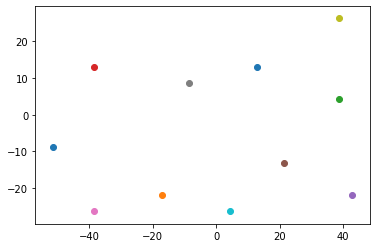

In [80]:
plt.figure()
for frame in frame_test:
    plt.scatter(x=frame[1], y=frame[0])

In [66]:
len(lsn.frames_unique)

151

In [20]:
def __init__(self, monitor, min_distance=20., grid_space=(10., 10.), probe_size=(10., 10.), probe_orientation=0.,
                 probe_frame_num=6, subregion=None, sign='ON-OFF', iteration=1, repeat=1):
        """

array([-34.9920202 , -30.61801767, -26.24401515, -21.87001262,
       -17.4960101 , -13.12200757,  -8.74800505,  -4.37400252,
         0.        ,   4.37400252,   8.74800505,  13.12200757,
        17.4960101 ,  21.87001262,  26.24401515,  30.61801767,
        34.9920202 ])

In [21]:
azi_probe_coords

array([-51.49934628, -47.20773409, -42.9161219 , -38.62450971,
       -34.33289752, -30.04128533, -25.74967314, -21.45806095,
       -17.16644876, -12.87483657,  -8.58322438,  -4.29161219,
         0.        ,   4.29161219,   8.58322438,  12.87483657,
        17.16644876,  21.45806095,  25.74967314,  30.04128533,
        34.33289752,  38.62450971,  42.9161219 ,  47.20773409,
        51.49934628])

In [22]:
probe_size = (4, 4)

grid_locations = []
for alt in alt_probe_coords:
    for azi in azi_probe_coords:
        grid_locations.append([alt, azi])

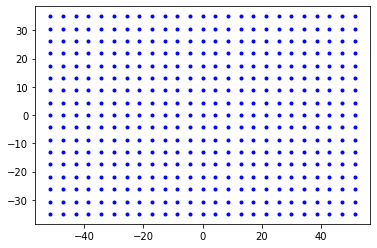

In [25]:
plt.figure()
plt.plot(grid_locations[:, 1], grid_locations[:, 0], 'b.')